# One-week forecast with Supervised Learning

Now that I have built some intuition about what makes individual bookings more likely to be canceled, maybe I can make a product useful to the company.

Many important logistical decisions in a hotel can likely only be made effectively with about a one week notice. Since time series analysis has not done anything to extend that window, perhaps another method can at least improve the quality of decisions withiin that window.

Since about 80% of bookings are made with at least one week notice, I may be able to effectively model the cancellation rate for at least the upcoming week. 

In [1]:
#Lbraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

#A standardized datetime object will be needed for some analyses

from datetime import datetime
from datetime import date
import calendar

In [2]:
df = pd.read_csv('processed_hotel_bookings.csv')

# Aggregation into weekly data

Now I need to process the data into weekly aggregates.

In [3]:
df['w_date'] = df.arrival_date_year.astype(str) + ' ' + df.arrival_date_week_number.astype(str) 
df['w_date'] = df['w_date'].apply(lambda x: datetime.strptime(x + ' 0', "%Y %W %w"))

In [4]:
w_deposit_df = pd.DataFrame(df[['deposit_score','w_date']].groupby(['w_date'], as_index=False).agg('mean'))
w_deposit_df = w_deposit_df.rename(index=str, columns={"deposit_score": "w_deposit"})
df = pd.merge(df,w_deposit_df,how='left',on='w_date')

In [5]:
w_agent_df = pd.DataFrame(df[['agent_cancel_score','w_date']].groupby(['w_date'], as_index=False).agg('mean'))
w_agent_df = w_agent_df.rename(index=str, columns={"agent_cancel_score": "w_agent"})
df = pd.merge(df,w_agent_df,how='left',on='w_date')

In [6]:
w_country_df = pd.DataFrame(df[['country_cancel_score','w_date']].groupby(['w_date'], as_index=False).agg('mean'))
w_country_df = w_country_df.rename(index=str, columns={"country_cancel_score": "w_country"})
df = pd.merge(df,w_country_df,how='left',on='w_date')

In [7]:
w_market_df = pd.DataFrame(df[['market_segment_score','w_date']].groupby(['w_date'], as_index=False).agg('mean'))
w_market_df = w_market_df.rename(index=str, columns={"market_segment_score": "w_market"})
df = pd.merge(df,w_market_df,how='left',on='w_date')

In [8]:
w_lead_time_df = pd.DataFrame(df[['lead_time','w_date']].groupby(['w_date'], as_index=False).agg('mean'))
w_lead_time_df = w_lead_time_df.rename(index=str, columns={"lead_time": "w_lead_time"})
df = pd.merge(df,w_lead_time_df,how='left',on='w_date')

In [9]:
parking_df = pd.DataFrame(df[['required_car_parking_spaces','w_date']].groupby(['w_date'], as_index=False).agg('mean'))
parking_df = parking_df.rename(index=str, columns={"required_car_parking_spaces": "w_parking"})
df = pd.merge(df,parking_df,how='left',on='w_date')

In [10]:
canceled_df = pd.DataFrame(df[['is_canceled','w_date']].groupby(['w_date'], as_index=False).agg('mean'))
canceled_df = canceled_df.rename(index=str, columns={"is_canceled": "w_canceled"})
df = pd.merge(df,canceled_df,how='left',on='w_date')

In [11]:
features_df = df[['w_canceled','w_deposit','w_agent','w_country','w_market','w_parking','w_lead_time','w_date']]

In [12]:
features_df = features_df.drop_duplicates()
features_df = features_df.reset_index()

In [13]:
features_df = features_df.drop(columns={'index'})

# The Models

In [23]:
#Model Evaluation Libraries
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score

#### Test/Train Split 

In [14]:
train_df = features_df[features_df['w_date'] <= '2017-05-31']
test_df = features_df[features_df['w_date'] > '2017-05-31']

In [15]:
# Y is the target variable
y_train = train_df['w_canceled']
y_test = test_df['w_canceled']

# X is the feature set
x_train = train_df[['w_deposit','w_agent','w_country','w_market','w_parking','w_lead_time']]
x_test = test_df[['w_deposit','w_agent','w_country','w_market','w_parking','w_lead_time']]

## Random Forest

In [16]:
#Random Forest Libraries
from sklearn import ensemble
from sklearn.model_selection import GridSearchCV

In [19]:
rfc = ensemble.RandomForestRegressor(n_jobs=-1)

#Hyper-parameter tuning
param_grid = { 
    'n_estimators': [200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['mse', 'mae']
}

CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5)
CV_rfc.fit(x_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=-1,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jobs

In [20]:
CV_rfc.best_params_

{'criterion': 'mae',
 'max_depth': 6,
 'max_features': 'auto',
 'n_estimators': 200}

In [27]:
rfc = ensemble.RandomForestRegressor(n_estimators=200, max_features='auto', max_depth=6, criterion='mae')

rfc.fit(x_train, y_train)

y_pred = rfc.predict(x_test)

cxval = cross_val_score(rfc, x_test, y_test, cv=5)

print(cxval)

[-0.31987441 -1.53971658 -0.13743912 -0.4977748  -8.23450599]


## Gradient Boosting

The results are so bad that no hyperparameter tuning will salvage them.

In [28]:
#Libraries
import scipy
from sklearn import ensemble
from IPython.display import Image
import pydotplus
import graphviz

#### Max Depth 2, default parameters

Weak learner 0 R^2: -4.502766697499152
Weak learner 20 R^2: -4.502766697499156


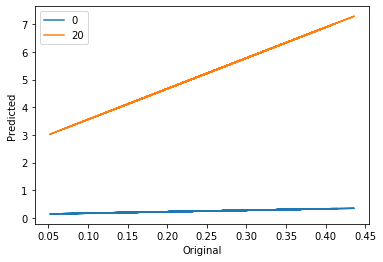

In [31]:
# Store values from loops.
preds = pd.DataFrame()
labels = []

uniquex = df['w_canceled'].unique()

for m in range(0, 21):
    
    # Initialize and fit the tree. Set the max depth to 2.
    gradient_boost = ensemble.GradientBoostingRegressor(max_depth=2)
    gradient_boost.fit(x_train,y_train)
    
    # Get and store predicted values.
    y_pred = gradient_boost.predict(x_test)
    preds['pred{}'.format(m)] = y_pred
    
    # Residuals.
    residuals = y_test - y_pred

    # Output every 20 iterations.
    if m % 20 == 0:
        print('Weak learner {} R^2: {}'.format(m, gradient_boost.score(x_test, y_test)))
        labels = labels + [m]
        bestpred = preds.sum(axis=1)
        plt.plot(uniquex, np.poly1d(np.polyfit(test_df['w_canceled'], bestpred, 1))(uniquex))
       
plt.legend(labels)
plt.xlabel('Original')
plt.ylabel('Predicted')
plt.show()
predicted = preds.sum(axis=1)

### Notebook Summary

In this notebook I tried to bridge the divide between my microspic look in Notebok 3 looking at singular bookings, and my macroscopic look in Notebook 2 looking at a Time Series Analysis. 

I aggregated the features that I engineered in Notebook 3 into weekly values by mean, and attempted to predict the cancellation rate for a given week. 

The results were absolutely useless, too a degree far beyond the models in Notebook 3.

Even if the results had been quite good, there would still be some missing pieces in the modeling pipeline:

- Only 80% of bookings are made with one-week lead time. 

- Of the 20% of bookings made with less than a week lead time, 36% are canceled.

Had the result been good, perhaps someone with greater domain knowledge or who has a better forecast for booking demand than what I have provided, could have used the model profitably.